In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [12]:
credit = pd.read_csv('../Credit.csv')

In [13]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [14]:
credit.shape

(1000, 21)

In [15]:
credit.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

Transformação básica de categórica pra numérica com o próprio pandas

In [16]:
for col in credit.columns:
    if credit[col].dtype == 'object':
        credit[col] = credit[col].astype('category').cat.codes

In [17]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [18]:
X = credit.iloc[:, 0:20].values #vai de 0 a 19
y = credit.iloc[:, 20].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criação do modelo e do experimento

In [20]:
def train_rf(n_estimators):
    mlflow. set_experiment("rfexperiment")
    
    with mlflow.start_run():
        rf =  RandomForestClassifier(n_estimators=n_estimators)
        rf.fit(X_train, y_train)
        prevs = rf.predict(X_test)
    
        #hyperparameters log
        mlflow.log_param("n_estimators", n_estimators)
        
        #metrics
        acc = accuracy_score(y_test, prevs)
        recall = recall_score(y_test, prevs)
        precision = precision_score(y_test, prevs)
        auc = roc_auc_score(y_test, prevs)
        log = log_loss(y_test, prevs)
    
        #register metrics
        mlflow.log_metric("Accuracy: ", acc)
        mlflow.log_metric("Recall: ", recall)
        mlflow.log_metric("Precision: ", precision)
        mlflow.log_metric("Auc: ", auc)
        mlflow.log_metric("Log: ", log)
    
        #plots
        confusion = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
        plt.savefig("confusionrf.png")
        roc = RocCurveDisplay.from_estimator(rf, X_test, y_test)
        plt.savefig("rocrf.png")
    
        #register plots
        mlflow.log_artifact("confusionrf.png")
        mlflow.log_artifact("rocrf.png")   
    
        #register model
        signature = infer_signature(X_train, rf.predict(X_train))
        mlflow.sklearn.log_model(rf,
                                 "RFmodel",
                                 signature=signature)
        
        #execution infos
        print("Model: ", mlflow.active_run().info.run_uuid)
    mlflow.end_run()

2025/02/05 11:05:39 INFO mlflow.tracking.fluent: Experiment with name 'rfexperiment' does not exist. Creating a new experiment.


Model:  8f0ce2208a5a4978aad2283a025d2c76


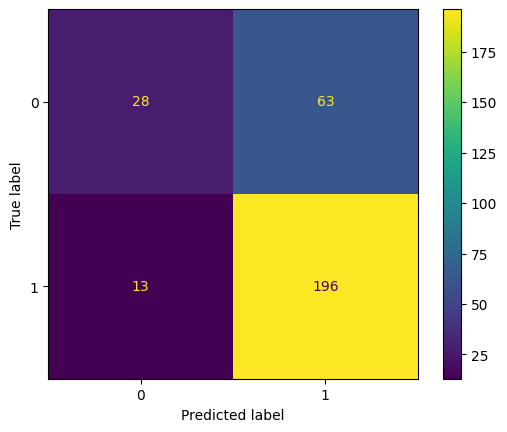

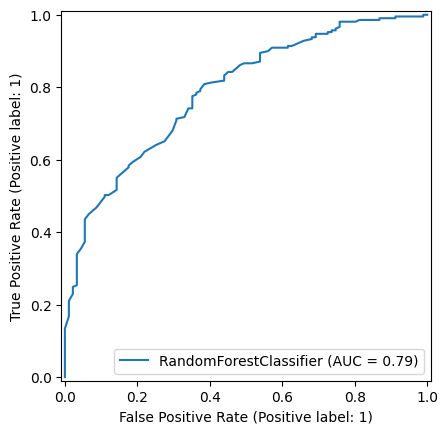

In [21]:
train_rf(200)